In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

#### Arxiv tool


In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Quesry arxiv papers")


#### wikipredia tool


In [3]:
api_wrapper_wiki= WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki,description="search wikipedia")

In [4]:
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

Tavily tool "Call apis"

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_search=TavilySearchResults(max_results=5)

tavily_search.run("What is the capital of France?")

/tmp/ipykernel_2857/138978059.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search=TavilySearchResults(max_results=5)


[{'title': 'Paris facts: the capital of France in history',
  'url': 'https://home.adelphi.edu/~ca19535/page%204.html',
  'content': 'page 4\n\n|  |  |  |  |  |  |  |\n| --- | --- | --- | --- | --- | --- | --- |\n| Home | Spain | Sydney | San Francisco | Paris | Las Vegas | Maui |\n\n  \nParis, France  \n\n  \n\n## Paris facts: Paris, the capital of France\n\nParis is the capital of France,\nthe largest country of Europe\nwith 550 000 km2 (65 millions inhabitants).\n\nParis has 2.234 million inhabitants\nend 2011. She is the core of Ile de France region (12 million\npeople). [...] Paris remained the capital of\nFrance until today, with one four year interruption. During\nGerman occupation (WW2 , 1940-1944), the capital of France was Vichy.\n\ngo to top\n\nReference: [...] ## Paris facts: the capital of France in history\n\nBefore Paris, the capital of France\nwas Lyon\n(under the Romans). Paris first became the capital of France in\n508 under King Clovis. After centuries with no unique

Combine tools


In [6]:
tools=[arxiv,wiki,tavily_search]


In [7]:
from langchain_groq import ChatGroq


llm=ChatGroq(model="llama-3.1-8b-instant",api_key=os.getenv("GROQ_API_KEY"))



In [8]:
llm.invoke("what is ai").content

'AI, or Artificial Intelligence, refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. The term can also be applied to any machine that exhibits traits associated with a human mind such as learning and problem-solving.\n\nAI technology is generally divided into two categories:\n\n1. **Narrow or Weak AI**: This type of AI is designed and trained to perform a specific task, such as image recognition, language translation, or playing a particular game. Narrow AI is trained on a specific dataset and is not capable of general reasoning or problem-solving outside its programming.\n\n2. **General or Strong AI**: This type of AI is designed to perform any intellectual task that a human can, and to continue learning and improving its abilities over time. General AI is still in the realm of science fiction, but researchers are actively working towards developing more advanced AI systems that can approach human levels of intelligence.\n\n**

In [9]:
llm_with_tools=llm.bind_tools(tools=tools)




In [10]:
llm_with_tools.invoke("what is the latest paper on langchain?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'pyv9j76mp', 'function': {'arguments': '{"query":"langchain latest paper"}', 'name': 'arxiv'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 398, 'total_tokens': 416, 'completion_time': 0.036051484, 'prompt_time': 0.138392475, 'queue_time': 0.09086540400000001, 'total_time': 0.174443959}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7f71cc00-b59c-45ea-9652-8bff06820a65-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'langchain latest paper'}, 'id': 'pyv9j76mp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 398, 'output_tokens': 18, 'total_tokens': 416})

##### Workflow

In [11]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

In [12]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


In [13]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

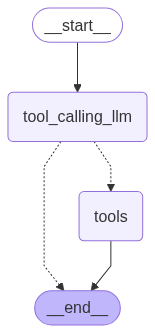

In [14]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}




builder=StateGraph(State)

builder.add_node("tool_calling_llm",tool_calling_llm)

builder.add_node("tools",ToolNode(tools=tools))



#add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", END)


graph=builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))








In [15]:


messages=graph.invoke({"messages":"my name is aly"})
for m in messages['messages']:
    m.pretty_print()
    










================================ Human Message =================================

my name is aly
================================== Ai Message ==================================
Tool Calls:
  wikipedia (g2hp4p2x7)
 Call ID: g2hp4p2x7
  Args:
    query: Aly
================================= Tool Message =================================
Name: wikipedia

Page: Aly Goni
Summary: Aly Goni (born 25 February 1991) is an Indian actor and model who appears in Hindi television. He made his debut through participating in MTV's dating reality show Splitsvilla 


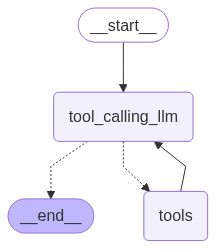

In [16]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}




builder=StateGraph(State)

builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools=tools))



#add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)

builder.add_edge("tools", "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)


graph=builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))








In [17]:
messages=graph.invoke({"messages":"What is the recent AI news and then please tell me the recent reseach paper on AI"})
for m in messages['messages']:
    m.pretty_print()
    

================================ Human Message =================================

What is the recent AI news and then please tell me the recent reseach paper on AI
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (t7978dt7z)
 Call ID: t7978dt7z
  Args:
    query: Recent AI news
  arxiv (df4qvrras)
 Call ID: df4qvrras
  Args:
    query: Recent AI research papers
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News | Latest AI News, Analysis & Events", "url": "https://www.artificialintelligence-news.com/", "content": "Anthropic deploys AI agents to audit models for safety · AGI. July 25, 2025 ; Sam Altman: AI will cause job losses and national security threats · Applications.", "score": 0.98584}, {"title": "Artificial Intelligence News - ScienceDaily", "url": "https://www.sciencedaily.com/news/computers_math/artificial_intelligence/", 

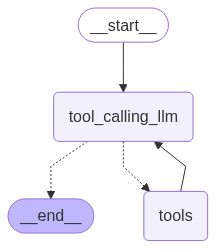

In [23]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


from langgraph.checkpoint.memory import MemorySaver


memory=MemorySaver()

builder=StateGraph(State)

builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools=tools))



#add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)

builder.add_edge("tools", "tool_calling_llm")



graph=builder.compile(checkpointer=memory)


display(Image(graph.get_graph().draw_mermaid_png()))








In [24]:
config={"configurable": {"thread_id": "2"}}


response=graph.invoke({"messages":["my name is aly"]},config=config)

response










{'messages': [HumanMessage(content='my name is aly', additional_kwargs={}, response_metadata={}, id='25dec1f5-c894-40e5-9094-e032f613cf20'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'v4tqszer1', 'function': {'arguments': '{"query":"Aly"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 394, 'total_tokens': 409, 'completion_time': 0.026193185, 'prompt_time': 0.171946009, 'queue_time': 0.09075063499999997, 'total_time': 0.198139194}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--76b8c611-ba79-4930-a8c2-f33613be4d6a-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Aly'}, 'id': 'v4tqszer1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 394, 'output_tokens': 15, 'total_tokens': 409}),
  ToolMessage(content="Page: Aly Goni\nSummary: Aly Goni (born 25 February 1

In [25]:
response=graph.invoke({"messages":"what us me name"},config=config)

response

{'messages': [HumanMessage(content='my name is aly', additional_kwargs={}, response_metadata={}, id='25dec1f5-c894-40e5-9094-e032f613cf20'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'v4tqszer1', 'function': {'arguments': '{"query":"Aly"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 394, 'total_tokens': 409, 'completion_time': 0.026193185, 'prompt_time': 0.171946009, 'queue_time': 0.09075063499999997, 'total_time': 0.198139194}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--76b8c611-ba79-4930-a8c2-f33613be4d6a-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Aly'}, 'id': 'v4tqszer1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 394, 'output_tokens': 15, 'total_tokens': 409}),
  ToolMessage(content="Page: Aly Goni\nSummary: Aly Goni (born 25 February 1

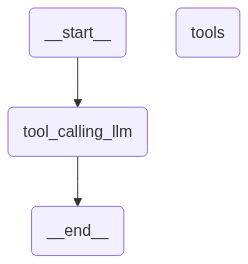

In [33]:
def superbit(state:State):
    return {"messages":[llm.invoke(state["messages"])]}


from langgraph.checkpoint.memory import MemorySaver


memory=MemorySaver()

builder=StateGraph(State)

builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools=tools))



#add edges
builder.add_edge(START, "tool_calling_llm")
# builder.add_conditional_edges("tool_calling_llm", tools_condition)

# builder.add_edge("tools", "tool_calling_llm")
builder.add_edge("tool_calling_llm",END)


graph=builder.compile(checkpointer=memory)


display(Image(graph.get_graph().draw_mermaid_png()))

Streaming


Methods: .stream() and astream()
• These methods are sync and async methods for streaming back results.
Additional parameters in streaming modes for graph state


⚫ values: This streams the full state of the graph after each node is called.
⚫ updates: This streams updates to the state of the graph after each node is called.


In [34]:
config={"configurable": {"thread_id": "3"}}


for chunk in graph.stream({"messages":"my name is aly and like to play fotball"},config,stream_mode="updates"):
    print(chunk)

{'tool_calling_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '7khae3xmk', 'function': {'arguments': '{"query":"Aly (given name)"}', 'name': 'wikipedia'}, 'type': 'function'}, {'id': 'dx760x0dy', 'function': {'arguments': '{"query":"Football player hobbies"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 400, 'total_tokens': 433, 'completion_time': 0.063539541, 'prompt_time': 0.093102045, 'queue_time': 0.09200971, 'total_time': 0.156641586}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--31a32286-18a6-4be6-9b9f-93d45cd45e02-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Aly (given name)'}, 'id': '7khae3xmk', 'type': 'tool_call'}, {'name': 'wikipedia', 'args': {'query': 'Football player hobbies'}, 'id': 'dx760x0dy', 'type': 'tool_call'}], usage_metad

In [35]:
for chunk in graph.stream({"messages":"i also like football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='my name is aly and like to play fotball', additional_kwargs={}, response_metadata={}, id='752ee694-64dc-48a4-83bf-0bfcf1bbd72a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '7khae3xmk', 'function': {'arguments': '{"query":"Aly (given name)"}', 'name': 'wikipedia'}, 'type': 'function'}, {'id': 'dx760x0dy', 'function': {'arguments': '{"query":"Football player hobbies"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 400, 'total_tokens': 433, 'completion_time': 0.063539541, 'prompt_time': 0.093102045, 'queue_time': 0.09200971, 'total_time': 0.156641586}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--31a32286-18a6-4be6-9b9f-93d45cd45e02-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Aly (given name)'}, 'id': '7khae3xmk', 'type': 'too

human intruption


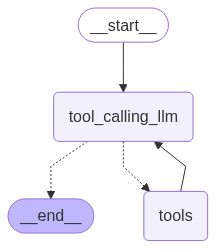

In [37]:
from langgraph.types import Command,interrupt
from langchain_core.tools import tool



memory=MemorySaver()

builder=StateGraph(State)
@tool
def human_assistant(query:str):
    """
    This tool is used to get human assistance.
    """
    humane_response=interrupt({"query": query})
    return humane_response["data"]


tools=[human_assistant,TavilySearchResults(max_results=2)]
llm_with_tools=llm.bind_tools(tools)

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}





builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools=tools))



#add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)

builder.add_edge("tools", "tool_calling_llm")
builder.add_edge("tool_calling_llm",END)


graph=builder.compile(checkpointer=memory)


display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
        {"messages": user_input},
        config,
        stream_mode="values",
    )
for event in events: 
    if "messages" in event: 
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistant (1a6c9tg0n)
 Call ID: 1a6c9tg0n
  Args:
    query: expert guidance for building an AI agent


In [39]:
human_response = (
"We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
"It's much more reliable and extensible than simple autonomous agents."
)
human_command = Command (resume={"data": human_response})
events=graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistant (1a6c9tg0n)
 Call ID: 1a6c9tg0n
  Args:
    query: expert guidance for building an AI agent
================================= Tool Message =================================
Name: human_assistant

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent.It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (vaxfvmt0c)
 Call ID: vaxfvmt0c
  Args:
    query: build AI agent LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph Tutorial - How to Build Advanced AI Agent Systems", "url": "https://www.youtube.com/watch?v=1w5cCXlh7JQ&pp=0gcJCfwAo7VqN5tD", "content": "In this video, you're going to learn how to build AI agen